<a href="https://colab.research.google.com/github/amitav710/SAiDL-Spring-Assignment-2022/blob/main/SRResNet_subpixel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Conv2D, ReLU, BatchNormalization, Add
from keras import layers
from tensorflow.keras.optimizers import Adam
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import PIL
import PIL.Image
import pathlib
from tensorflow.keras.utils import plot_model

In [ ]:
ds_train, info_train = tfds.load('oxford_iiit_pet', split='train', with_info=True, shuffle_files=False, as_supervised=True)
df_train = tfds.as_dataframe(ds_train.take(5), info_train)
df_train.head()

,image,label
0,"[[[3, 3, 3], [5, 3, 4], [7, 5, 6], [4, 2, 3], ...",33
1,"[[[5, 9, 8], [3, 4, 0], [11, 24, 4], [36, 51, ...",12
2,"[[[44, 32, 6], [44, 34, 7], [44, 34, 7], [41, ...",9
3,"[[[108, 130, 117], [114, 133, 127], [108, 128,...",32
4,"[[[237, 228, 91], [236, 228, 93], [230, 225, 8...",33


In [ ]:
x_train=[]
for data in ds_train:
  x,_ = data
  x=x.numpy()
  x=cv2.resize(x, (300,300))
  x_train.append(x)
x_train = np.array(x_train)
x_train.shape

(3680, 300, 300, 3)

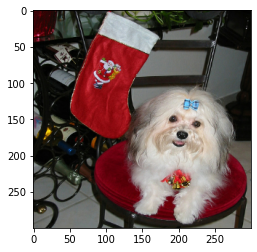

In [ ]:
plt.imshow(x_train[77])

# Converting into Low-Res Image by Downscaling and Blurring

In [ ]:
!pip install tensorflow_addons==0.15

In [ ]:
import tensorflow_addons as tfa

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
def lowres(img:np.ndarray): #dealing with 0 to 1 float values after conversion
  img=tfa.image.gaussian_filter2d(img, filter_shape=(3,3))
  new=tf.image.resize(img, (100,100), method=tf.image.ResizeMethod.AREA, preserve_aspect_ratio=False, antialias=False)
  return new/255

In [ ]:
inputs=[]
for i in x_train:
  a=lowres(i)
  inputs.append(a)
inputs=np.array(inputs)

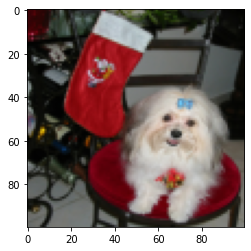

In [ ]:
plt.imshow(inputs[77])

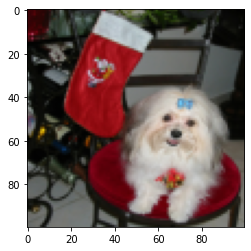

In [ ]:
plt.imshow(lowres(x_train[77]))

## Loading our Weights

In [ ]:
!pwd

/content


In [ ]:
pb_model = "./subpixel_wts"
# Loading the Tensorflow Saved Model (PB)
SRResNet = tf.keras.models.load_model(pb_model)
print(SRResNet.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 100, 100, 64  4864        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 100, 100, 64  102464      ['conv2d_15[0][0]']              
                                )                                                           

# Building our ResNet model

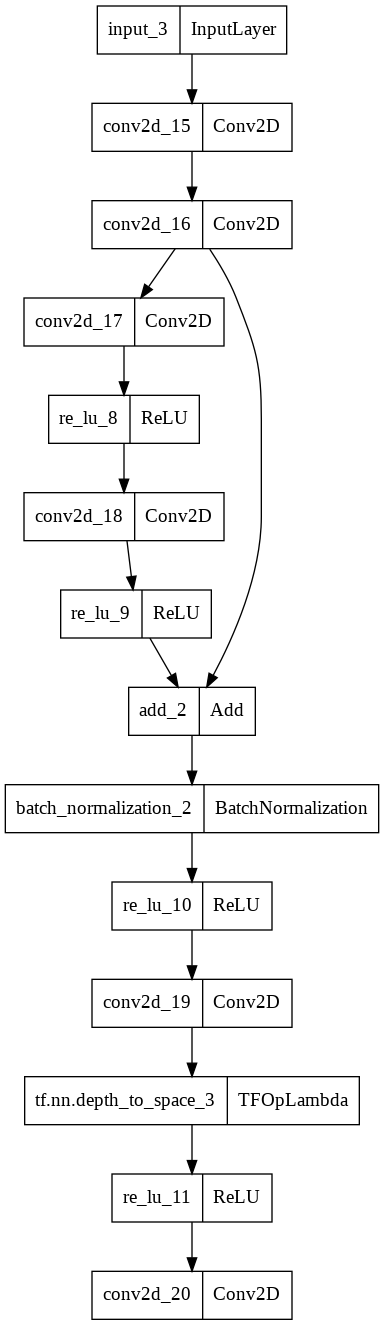

In [ ]:
shape=(100,100,3)
input=layers.Input(shape)

x = (Conv2D(filters=64, kernel_size = (5, 5), kernel_initializer='glorot_uniform', activation='relu', padding='same', use_bias=True, input_shape=(100, 100, 3)))(input)
x = (Conv2D(filters=64, kernel_size = (5, 5), kernel_initializer='glorot_uniform', activation='relu', padding='same', use_bias=True))(x)
xcopy1=x

x1 = (Conv2D(filters=64, kernel_size = (5, 5), kernel_initializer='glorot_uniform', activation='relu', padding='same'))(xcopy1)
x1 = (ReLU())(x1)
x1 = (Conv2D(filters=64, kernel_size = (5, 5), kernel_initializer='glorot_uniform', activation='relu', padding='same'))(x1)
x1 = (ReLU())(x1)

x=Add()([xcopy1,x1])
x = (BatchNormalization(momentum=0.02))(x)
x = (ReLU())(x)

x=(Conv2D(filters=27, kernel_size = (3, 3), kernel_initializer='glorot_uniform', activation="relu", padding= "same"))(x)
x=tf.nn.depth_to_space(x, 3) #our upscale factor
x = (ReLU())(x)

x= (Conv2D(filters=3, kernel_size = (3, 3), kernel_initializer='glorot_uniform', activation='relu', padding='same', use_bias=True))(x)

SRResNet = tf.keras.Model(inputs=input, outputs=x)
plot_model(SRResNet)

In [ ]:
adam = Adam(learning_rate=0.0001)

In [ ]:
SRResNet.compile(optimizer= adam, loss='mean_squared_error', metrics=['mean_squared_error'], run_eagerly=True)

In [ ]:
early_stop=keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=10, mode='min', restore_best_weights=True)

In [ ]:
model_save_location='subpixel_wts'

In [ ]:
checkpoint=keras.callbacks.ModelCheckpoint(model_save_location, monitor='mean_squared_error', save_best_only=True, mode='min')

In [ ]:
SRResNet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 100, 100, 64  4864        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 100, 100, 64  102464      ['conv2d_15[0][0]']              
                                )                                                           

In [ ]:
history=SRResNet.fit(x=inputs, y=x_train, epochs=75, batch_size=32, callbacks=[early_stop, checkpoint])

Epoch 1/75
115/115 [==============================] - ETA: 0s - loss: 179.0444 - mean_squared_error: 179.0444INFO:tensorflow:Assets written to: subpixel_wts/assets


INFO:tensorflow:Assets written to: subpixel_wts/assets


115/115 [==============================] - 41s 360ms/step - loss: 179.0444 - mean_squared_error: 179.0444
Epoch 2/75
115/115 [==============================] - ETA: 0s - loss: 177.1286 - mean_squared_error: 177.1286INFO:tensorflow:Assets written to: subpixel_wts/assets


INFO:tensorflow:Assets written to: subpixel_wts/assets


115/115 [==============================] - 41s 356ms/step - loss: 177.1286 - mean_squared_error: 177.1286
Epoch 3/75
115/115 [==============================] - 39s 342ms/step - loss: 184.3309 - mean_squared_error: 184.3309
Epoch 4/75
115/115 [==============================] - ETA: 0s - loss: 168.0284 - mean_squared_error: 168.0284INFO:tensorflow:Assets written to: subpixel_wts/assets


INFO:tensorflow:Assets written to: subpixel_wts/assets


115/115 [==============================] - 41s 355ms/step - loss: 168.0284 - mean_squared_error: 168.0284
Epoch 5/75
115/115 [==============================] - 39s 341ms/step - loss: 171.0477 - mean_squared_error: 171.0478
Epoch 6/75
115/115 [==============================] - 39s 341ms/step - loss: 174.1641 - mean_squared_error: 174.1641
Epoch 7/75
115/115 [==============================] - 39s 342ms/step - loss: 176.7665 - mean_squared_error: 176.7666
Epoch 8/75
115/115 [==============================] - 39s 341ms/step - loss: 174.1010 - mean_squared_error: 174.1009
Epoch 9/75
115/115 [==============================] - 39s 341ms/step - loss: 177.5793 - mean_squared_error: 177.5793
Epoch 10/75
115/115 [==============================] - 39s 341ms/step - loss: 176.1305 - mean_squared_error: 176.1305
Epoch 11/75
115/115 [==============================] - 39s 341ms/step - loss: 173.5798 - mean_squared_error: 173.5798
Epoch 12/75
115/115 [==============================] - 39s 341ms/step - l

In [ ]:
ds_test, info_test = tfds.load('oxford_iiit_pet', split='test', with_info=True, shuffle_files=False, as_supervised=True)
df_test = tfds.as_dataframe(ds_test.take(5), info_test)
df_test.head()

,image,label
0,"[[[250, 241, 232], [255, 247, 238], [251, 244,...",19
1,"[[[4, 6, 3], [4, 6, 3], [4, 6, 3], [3, 5, 2], ...",20
2,"[[[100, 120, 33], [103, 123, 38], [96, 115, 34...",28
3,"[[[182, 145, 126], [179, 143, 117], [177, 145,...",28
4,"[[[184, 188, 199], [178, 185, 195], [180, 186,...",4


In [ ]:
x_test=[]
for data in ds_test:
  x,_ = data
  x=x.numpy()
  x=cv2.resize(x, (300,300))
  x_test.append(x)
x_test = np.array(x_test)
x_test.shape

(3669, 300, 300, 3)

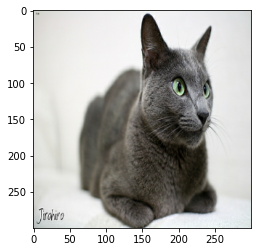

In [ ]:
plt.imshow(x_test[100])

In [ ]:
out=SRResNet.predict(np.expand_dims(lowres(x_test[100]), axis=0))

In [ ]:
out=out/255

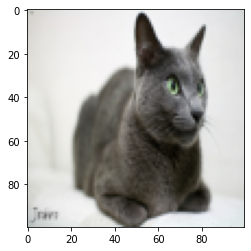

In [ ]:
plt.imshow(lowres(x_test[100]))

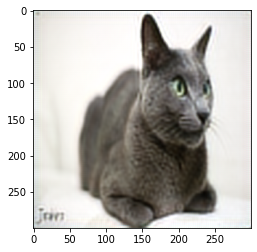

In [ ]:
plt.imshow(out[0])

In [ ]:
tf.image.psnr(out[0], x_test[100], 1.0)

<tf.Tensor: shape=(), dtype=float32, numpy=26.036636>